# Fuzzy Suitability Analysis

In [47]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from rasterio.enums import Resampling
import numpy as np

from rasterio.features import geometry_mask
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

### Load data

In [77]:
farm = gpd.read_file(r"./farm/farm_modern.shp")
farm.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (249005.828 481581.281)
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507950,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,558.0,POINT (253627.284 494018.877)
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507953,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,559.0,POINT (255218.985 489726.124)
3,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507962,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,560.0,POINT (247910.764 494942.485)
4,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507964,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,561.0,POINT (229912.777 473407.567)


In [49]:
road = gpd.read_file(r"./osm_network/G_e.shp")
road.head()

,u,v,key,highway,geometry
0,0,1,0,primary,"LINESTRING (732329.118 6863326.894, 732282.965..."
1,0,2,0,primary,"LINESTRING (732329.118 6863326.894, 732424.976..."
2,1,0,0,primary,"LINESTRING (732029.302 6862992.539, 732169.520..."
3,1,491,0,primary,"LINESTRING (732029.302 6862992.539, 731998.678..."
4,2,3,0,motorway_link,"LINESTRING (732826.405 6863768.536, 732776.088..."


In [50]:
road = road.to_crs("EPSG:28992")

In [51]:
lu = rasterio.open(r'./raster/agri_clip.tif')

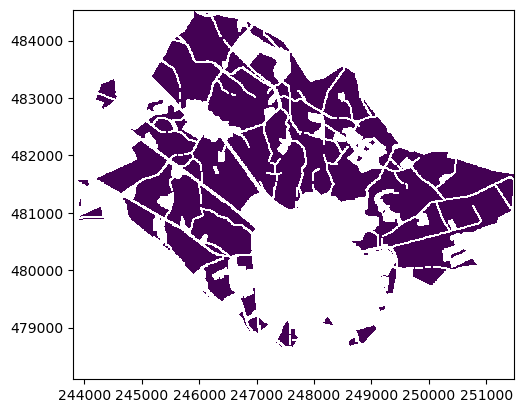

<Axes: >

In [52]:
show(lu)

In [53]:
lu.count

1

In [54]:
print(lu.width, lu.height)

768 644


In [55]:
lu.indexes

(1,)

In [56]:
band1 = lu.read(1)
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [57]:
band1[lu.height // 2, lu.width // 2]

4

In [24]:
lu.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 768,
 'height': 644,
 'count': 1,
 'crs': CRS.from_epsg(28992),
 'transform': Affine(10.0, 0.0, 243799.6719999984,
        0.0, -10.0, 484538.0309999995)}

In [64]:
# Load raster data
with rasterio.open(r'./raster/agri_clip.tif') as src:
    LU = src.read(1)  # Assuming it is a single band raster

In [68]:
LU.shape

(644, 768)

### Calculate distances

In [26]:
# # Convert shapefile points to a format that can be used for distance calculations
# points = [(x, y) for x, y in zip(farm.geometry.x, farm.geometry.y)]

In [28]:
# # Generate a mask for the raster
# raster_mask = geometry_mask(farm.geometry, out_shape=lu.shape, transform=lu.transform, invert=True)

In [69]:
# Initialize an empty array to store the distances
distances_farm = np.ones_like(LU) * np.inf

In [78]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        cell_center = src.xy(row, col)
        point = Point(cell_center)

        # Calculate distances to farms
        for _, f in farm.iterrows():
            distance = point.distance(f.geometry)
            if distance < distances_farm[row, col]:
                distances_farm[row, col] = distance

KeyboardInterrupt: 